In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

class Panela:
    def __init__(self, arquivo):
        self.arquivo = arquivo
        self.df_principal = self.carregar_arquivo()
        self.df_produto = pd.DataFrame()
        self.df_produto_ml = pd.DataFrame()
        
        self.carregar_produto()
        
    def carregar_arquivo(self):
        '''Carregar arquivo e renomear colunas'''
        df_principal = pd.read_csv(self.arquivo)
        df_principal.rename(columns={'CAPACIDADE_(L)':'CAPACIDADE'},inplace=True)
        return df_principal

    def carregar_produto(self):
        '''Retornar os produtos únicos'''
        self.df_produto = self.df_principal[['ITEM_ID', 'ALTURA', 
                                             'CAPACIDADE', 'COMPOSICAO', 
                                             'COR', 'FORMATO',
                                             'LARGURA', 'MARCA', 
                                             'PARA_LAVA_LOUCAS', 'PARA_MICRO_ONDAS', 
                                             'PESO','PROFUNDIDADE', 
                                             'TEMPO_GARANTIA', 'TEM_FERRO_FUNDIDO', 
                                             'TEM_GRELHA','TEM_TAMPA', 
                                             'TIPO_PRODUTO', 'TIPO_WOK', 
                                             'ITEM_PRICE','INTERESTED']].drop_duplicates()
        self.df_produto = self.df_produto.reset_index(drop=True)
        self.tratar_coluna_produto()
        self.imputar_dado_produto()
        self.calcular_dado_produto()
    
    def tratar_coluna_produto(self):
        '''Tratar colunas do dataframe de produtos'''
        
        #Produtos sem preço não são vendáveis
        self.df_produto.drop(self.df_produto[(self.df_produto.ITEM_PRICE.isnull())].index, inplace=True)
        self.df_produto = self.df_produto.reset_index(drop=True)
        #Produtos com a garantia nula, é atribuído 0
        self.df_produto.TEMPO_GARANTIA[self.df_produto.TEMPO_GARANTIA.isnull()] = 0
        
        self.df_produto.TIPO_WOK = np.where(self.df_produto.TIPO_WOK == 'NAO', 0, 1)
        self.df_produto.TEM_GRELHA = np.where(self.df_produto.TEM_GRELHA == 'NAO', 0, 1)
        self.df_produto.TEM_FERRO_FUNDIDO = np.where(self.df_produto.TEM_FERRO_FUNDIDO == 'NAO', 0, 1)
        
        self.df_produto.PARA_LAVA_LOUCAS[self.df_produto.PARA_LAVA_LOUCAS == 'NAO'] = 'No'
        self.df_produto.PARA_LAVA_LOUCAS = np.where(self.df_produto.PARA_LAVA_LOUCAS == 'NAO', 0, 
                                                    np.where(self.df_produto.PARA_LAVA_LOUCAS == 'SIM',1,-1))
                                                    
        self.df_produto.PARA_MICRO_ONDAS = np.where(self.df_produto.PARA_MICRO_ONDAS == 'no', 0, 
                                                    np.where(self.df_produto.PARA_MICRO_ONDAS == 'yes',1,-1))
        
    def imputar_dado_produto(self):
        '''Atribuir valores para itens sem classificação'''
        self.df_produto.FORMATO[self.df_produto.FORMATO.isnull()] = 'INDEFINIDO'
        self.df_produto.COMPOSICAO[self.df_produto.COMPOSICAO.isnull()] = 'INDEFINIDO'
        self.df_produto.COR[self.df_produto.COR.isnull()] = 'INDEFINIDO'
        self.df_produto.MARCA[self.df_produto.MARCA.isnull()] = 'INDEFINIDO'
    
    def classificar_literal_produto(self):
        '''Transforma as colunas do tipo string em números '''
        self.df_produto_ml = self.df_produto.copy()
        
        if 'COMPOSICAO' in self.df_produto.columns:
            self.df_produto_ml = self.df_produto_ml.join(pd.get_dummies(self.df_produto_ml.COMPOSICAO, prefix='COMPOSICAO'))
            self.df_produto_ml.drop(columns=['COMPOSICAO'],inplace=True)
        
        if 'COR' in self.df_produto.columns:        
            self.df_produto_ml = self.df_produto_ml.join(pd.get_dummies(self.df_produto_ml.COR, prefix='COR'))
            self.df_produto_ml.drop(columns=['COR'],inplace=True)
            
        if 'MARCA' in self.df_produto.columns:        
            self.df_produto_ml = self.df_produto_ml.join(pd.get_dummies(self.df_produto_ml.MARCA, prefix='MARCA'))
            self.df_produto_ml.drop(columns=['MARCA'],inplace=True)

        if 'TIPO_PRODUTO' in self.df_produto.columns:
            self.df_produto_ml = self.df_produto_ml.join(pd.get_dummies(self.df_produto_ml.TIPO_PRODUTO, prefix='TIPO_PRODUTO'))

        if 'FORMATO' in self.df_produto.columns:
            self.df_produto_ml = self.df_produto_ml.join(pd.get_dummies(self.df_produto_ml.FORMATO, prefix='FORMATO'))
            self.df_produto_ml.drop(columns=['FORMATO'],inplace=True)
            
    def testar_dado_produto(self, escalar=False, excluir_linha_nulo=True):        
        if excluir_linha_nulo:
            #Tipos de produtos que não tem dados em algumas colunas
            lst_tipo = self.df_produto_ml[(self.df_produto_ml.CAPACIDADE.isnull()) | (self.df_produto_ml.ALTURA.isnull()) |
                              (self.df_produto_ml.LARGURA.isnull()) | (self.df_produto_ml.PROFUNDIDADE.isnull()) |
                             (self.df_produto_ml.PESO.isnull())].TIPO_PRODUTO.unique()
            self.df_produto_ml.drop(self.df_produto_ml[self.df_produto_ml.TIPO_PRODUTO.isin(lst_tipo)].index, inplace=True)
        
        if escalar:
            coluna_escala = ['ALTURA','CAPACIDADE','LARGURA','PESO','PROFUNDIDADE','TEMPO_GARANTIA','ITEM_PRICE']
            coluna_existe = [item for item in self.df_produto_ml.columns if item in coluna_escala]
            
            df_escala = self.df_produto_ml[coluna_existe].copy()
            scaler = preprocessing.StandardScaler().fit(df_escala.values)
            self.df_produto_ml[coluna_existe] = scaler.transform(df_escala.values)
        
        SEED = 42
        np.random.seed(SEED)
        
        #excluir colunas para o teste
        coluna = [item for item in self.df_produto_ml.columns if item not in ['ITEM_ID','TIPO_PRODUTO','INTERESTED']]
        
        X_train, X_test, y_train, y_test = train_test_split(self.df_produto_ml[coluna], 
                                                            self.df_produto_ml['INTERESTED'], 
                                                            test_size = 0.20)
        return X_train, X_test, y_train, y_test
        
    def aplicar_ml(self, escalar=False, excluir_linha_nulo=True, sem_kfold=False):        

        SEED = 42
        np.random.seed(SEED)
        X_train, X_test, y_train, y_test = self.testar_dado_produto(escalar, excluir_linha_nulo)

        cv = StratifiedKFold(n_splits = 5, shuffle = True)
        model = DecisionTreeClassifier(max_depth=5)
        model_svc = SVC() #kernel='linear'
        model_log = LogisticRegression(solver='liblinear')
        model_rand = RandomForestClassifier(n_estimators=200)
        models = [model, model_svc, model_log, model_rand]
        #models = [model_rand]
        name = ['Árvore de Decisão', 'SVC', 'Regressão Logística', 'Random Forest']
        #name = ['Random Forest']
        index = 0
        for item in models:
            np.random.seed(SEED)
            
            if sem_kfold:
                item.fit(X_train, y_train)
                y_predict = item.predict(X_train)
            else:
                results = cross_val_score(item, X_train, y_train, cv = cv, scoring = 'accuracy')
                feature = cross_validate(item, X_train, y_train, cv=cv, scoring = 'accuracy', return_estimator =True)
                media = results.mean()
                desvio = results.std()
                y_predict = cross_val_predict(item, X_train, y_train, cv = cv)
            
            print('-'*100)
            print('Modelo {}'.format(name[index]))
            print('Matriz de Confusão:')
            plt.figure(figsize=(5, 5))
            sns.heatmap(confusion_matrix(y_train, y_predict), 
                        annot=True, linewidth=.1, 
                        fmt='.1f', cmap='Reds', 
                        square=True, cbar=False)
            plt.show()
            
            if sem_kfold:
                print ("A acurácia foi de {:.2f}%.".format(accuracy_score(y_train, y_predict) * 100))
            else:
                print('Acurácia média: {:.2f}%'.format(media*100))
                print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((media - 2*desvio)*100, (media + 2*desvio)*100))           
            
            try:
                if sem_kfold:
                    lst_atributo = sorted(list(zip(X_train.columns, item.feature_importances_)), 
                                          key=lambda x : x[1], reverse=True)[:5]
                    print('Atributos mais relevantes para a decisão se o produto é interessante/não interessante')
                    for item in lst_atributo:
                        print('Atributo: {} - Importância: {:.10f}%'.format(item[0], item[1] * 100))
                else:    
                    for indice, estimator in enumerate(feature['estimator']):
                        print('Atributos mais relevantes para a decisão se o produto é interessante/não interessante - estimador {}'.format(indice))
                        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                                           index = X_train.columns,
                                                            columns=['importance']).sort_values('importance', ascending=False)
                        for i, linha in feature_importances.head(5).iterrows():
                            print('Atributo: {} - Importância: {:.10f}%'.format(linha.name, linha[0] * 100))
                        print(' ')
                    
            except:
                print('Não implementado o classificador')
                
                
            index += 1
    
    def calcular_dado_produto(self):
        '''Calcular a média dos atributos por tipo de produto'''
        def calcular(tipo, coluna):
            media = np.mean(self.df_produto[coluna][(self.df_produto.TIPO_PRODUTO == tipo)], axis=0)
            desvio = np.std(self.df_produto[coluna][(self.df_produto.TIPO_PRODUTO == tipo)], axis=0)
            media_final = np.mean(self.df_produto[coluna][(self.df_produto.TIPO_PRODUTO ==  tipo) &
                                                          (self.df_produto[coluna] >= media - 2 * desvio) &
                                                          (self.df_produto[coluna] <= media + 2 * desvio)], axis=0)
            return round(media_final,2)
        
        lst_altura = {item: calcular(item, 'ALTURA') for item in self.df_produto.TIPO_PRODUTO.unique()}
        lst_capacidade = {item: calcular(item, 'CAPACIDADE') for item in self.df_produto.TIPO_PRODUTO.unique()}
        lst_largura = {item: calcular(item, 'LARGURA') for item in self.df_produto.TIPO_PRODUTO.unique()}
        lst_peso = {item: calcular(item, 'PESO') for item in self.df_produto.TIPO_PRODUTO.unique()}
        lst_profundidade = {item: calcular(item, 'PROFUNDIDADE') for item in self.df_produto.TIPO_PRODUTO.unique()}

        self.df_produto.ALTURA[self.df_produto.ALTURA.isnull()] = self.df_produto.TIPO_PRODUTO[self.df_produto.ALTURA.isnull()].apply(lambda x: lst_altura[x])
        self.df_produto.CAPACIDADE[self.df_produto.CAPACIDADE.isnull()] = self.df_produto.TIPO_PRODUTO[self.df_produto.CAPACIDADE.isnull()].apply(lambda x: lst_capacidade[x])
        self.df_produto.LARGURA[self.df_produto.LARGURA.isnull()] = self.df_produto.TIPO_PRODUTO[self.df_produto.LARGURA.isnull()].apply(lambda x: lst_largura[x])
        self.df_produto.PESO[self.df_produto.PESO.isnull()] = self.df_produto.TIPO_PRODUTO[self.df_produto.PESO.isnull()].apply(lambda x: lst_peso[x])
        self.df_produto.PROFUNDIDADE[self.df_produto.PROFUNDIDADE.isnull()] = self.df_produto.TIPO_PRODUTO[self.df_produto.PROFUNDIDADE.isnull()].apply(lambda x: lst_profundidade[x])

In [2]:
panela = Panela('problem1_dataset.csv')

<h4>ANÁLISE DESCRITIVA</h4>

Verifiquei os tipos das colunas, e as possíveis colunas que deverão ser tratadas para aplicar o modelo

In [3]:
panela.df_principal.dtypes

ITEM_ID                int64
ALTURA               float64
CAPACIDADE           float64
COMPOSICAO            object
COR                   object
FORMATO               object
LARGURA              float64
MARCA                 object
PARA_LAVA_LOUCAS      object
PARA_MICRO_ONDAS      object
PESO                 float64
PROFUNDIDADE         float64
TEMPO_GARANTIA       float64
TEM_FERRO_FUNDIDO     object
TEM_GRELHA            object
TEM_TAMPA            float64
TIPO_PRODUTO          object
TIPO_WOK              object
SESSION_ID           float64
ITEM_PRICE           float64
INTERESTED           float64
dtype: object

Verifiquei a discrepância do desvio padrão nas colunas númericas para verificar a variação do dados<br>

In [4]:
panela.df_principal[['ALTURA','CAPACIDADE','LARGURA','PESO','PROFUNDIDADE','TEMPO_GARANTIA','ITEM_PRICE']].describe()

,ALTURA,CAPACIDADE,LARGURA,PESO,PROFUNDIDADE,TEMPO_GARANTIA,ITEM_PRICE
count,171007.000000,76671.000000,171007.000000,98524.000000,171007.000000,122770.000000,167178.000000
mean,30.575636,4.234668,27.882157,311.259118,34.797386,13.870742,127.831019
std,14.856403,1.699274,10.494943,1727.585999,15.179911,43.641581,137.298241
min,2.000000,0.045000,4.500000,0.619000,2.500000,1.000000,0.550000
25%,19.000000,3.100000,20.000000,120.000000,19.800000,3.000000,74.990000
50%,30.500000,4.500000,27.800000,160.000000,38.500000,6.000000,104.482418
75%,42.700000,6.000000,35.000000,190.000000,47.000000,12.000000,146.327727
max,84.000000,11.000000,91.000000,44400.000000,148.000000,300.000000,2274.990000


Verifiquei se havia outliers nessas colunas<br>

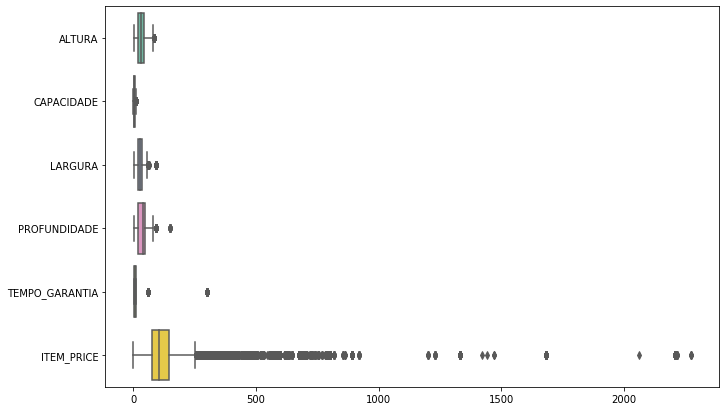

In [5]:
plt.figure(figsize=(11,7))
sns.boxplot(data=panela.df_principal[['ALTURA', 'CAPACIDADE','LARGURA', 
                                        'PROFUNDIDADE', 'TEMPO_GARANTIA', 'ITEM_PRICE']], orient="h", palette="Set2");

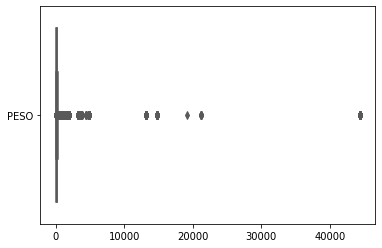

In [6]:
sns.boxplot(data=panela.df_principal[['PESO']], orient="h", palette="Set2");

Verificação das colunas, para entender se existem colunas altamente correlacionadas

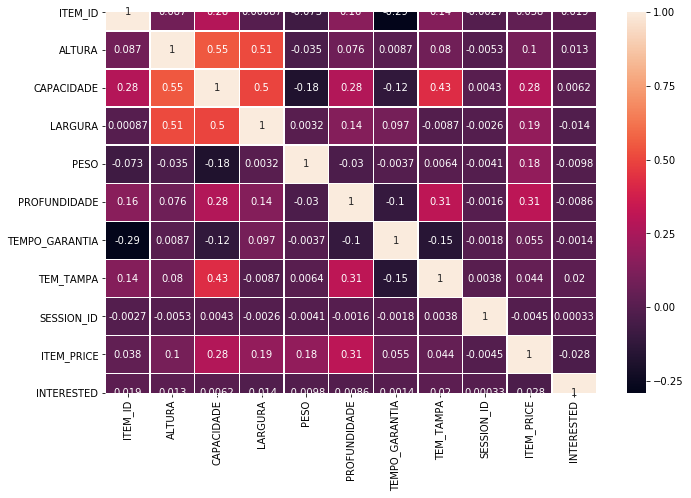

In [7]:
plt.figure(figsize=(11,7))
sns.heatmap(panela.df_principal.corr(), annot=True, linewidths=.5);

Verifiquei a quantidade de valores nulos nas colunas e quais provavelmente devem ser tratadas

In [8]:
panela.df_principal.isnull().sum()

ITEM_ID                   0
ALTURA                 9268
CAPACIDADE           103604
COMPOSICAO            23297
COR                   10024
FORMATO               90264
LARGURA                9268
MARCA                   274
PARA_LAVA_LOUCAS      76189
PARA_MICRO_ONDAS      93873
PESO                  81751
PROFUNDIDADE           9268
TEMPO_GARANTIA        57505
TEM_FERRO_FUNDIDO         0
TEM_GRELHA                0
TEM_TAMPA                 0
TIPO_PRODUTO              0
TIPO_WOK                  0
SESSION_ID             2002
ITEM_PRICE            13097
INTERESTED                0
dtype: int64

Listei todos os tipos de produtos no dataset para entender com quantos tipos vamos trabalhar

In [9]:
panela.df_principal.TIPO_PRODUTO.unique()

array(['PANELA', 'PIPOQUEIRA', 'ESPAGUETEIRA', 'CREMEIRA', 'WOK',
       'CACAROLA', 'CUSCUZEIRA', 'CHAPA', 'CHALEIRA', 'FRIGIDEIRA',
       'FERVEDOR', 'SANDUICHEIRA', 'FONDUE', 'MINI-CACAROLA',
       'OMELETEIRA', 'PAELLERA', 'BIFETEIRA', 'CALDEIRAO', 'CUMBUCA',
       'PANQUEQUEIRA', 'FRITADEIRA', 'FOGAREIRO', 'FORMA', 'LEITEIRA',
       'GRILL', 'BULE', 'COZI-VAPORE', 'ASSADEIRA', 'TAMPA', 'COZI-PASTA',
       'PRENSADOR', 'CUSCUZEIRO', 'FORNO', 'PAPEIRO', 'BISTEQUEIRA',
       'CANECO', 'VAPORELLA', 'CANECA/FERVEDOR'], dtype=object)

<h4>TRATAMENTO DOS DADOS</h4>

- Como em algumas colunas o desvio padrão é alto, apliquei um balanceamento nos dados (<i>StandardScaler</i>) afim de mitigar possíveis problemas decorrente da variação dos dados
- Exclui as linhas aonde não havia preço, porque se um produto não tem preço não pode ser vendido
- Em algumas colunas aonde não tinham valores, apliquei a média agrupada por tipo de produto. Por exemplo, os tipos dos produtos <b>"PANELA"</b> que não tinham o atributo largura preenchido, atribui a esse produto a média da largura do tipo de produto <b>"PANELA"</b>.
- Defini como <b>"INDEFINIDO"</b> os produtos que não tinham valores nos campo categóricos

In [10]:
panela.df_produto.sample(5)

,ITEM_ID,ALTURA,CAPACIDADE,COMPOSICAO,COR,FORMATO,LARGURA,MARCA,PARA_LAVA_LOUCAS,PARA_MICRO_ONDAS,PESO,PROFUNDIDADE,TEMPO_GARANTIA,TEM_FERRO_FUNDIDO,TEM_GRELHA,TEM_TAMPA,TIPO_PRODUTO,TIPO_WOK,ITEM_PRICE,INTERESTED
596,14581492,32.0,4.5,ALUMINIO,PRETO,INDEFINIDO,32.0,TRAMONTINA,-1,0,20.00,15.0,12.0,0,0,1.0,PANELA,1,92.490000,0.0
2011,258463516,16.5,5.5,ALUMINIO,PRATA,INDEFINIDO,24.0,BRINOX,-1,-1,120.24,34.5,0.0,0,0,0.0,ESPAGUETEIRA,0,98.847143,0.0
122,240761706,8.5,1.5,ALUMINIO,VERMELHO,INDEFINIDO,25.0,MTA,-1,0,180.00,48.5,3.0,0,0,0.0,FRIGIDEIRA,0,199.000000,0.0
4405,255997894,14.0,2.3,ALUMINIO,PRETO,REDONDO,20.0,DONA CHEFA,-1,-1,165.75,37.0,6.0,0,0,1.0,PANELA,0,49.990000,0.0
3212,242171044,19.0,NaN,INOX,INOX,INDEFINIDO,15.5,TRAMONTINA,-1,0,110.00,22.0,12.0,0,0,0.0,CUSCUZEIRA,0,160.435833,0.0


Como existem alguns tipos de produtos que não existem atributos preenchidos, esses tipos de produtos serão tratados de forma separada. A minha decisão em não excluí-los foi tomada analisando que caso eles fosse excluídos, deixaria de fora da predição alguns tipos de produtos inteiros. Por exemplo, o tipo de produto <b>CREMEIRA</b>, não possui o campo <b>ALTURA</b> preenchido. Esse tipo de produto, será tratado de forma separada dos demais.

<h4>PREDIÇÃO</h4>

Realizei testes em 4 modelos de predição supervisionados: <b>SVC, Árvore de decisão, Floresta aleatória e Regressão Logística</b>. 
Analisando a matriz de confusão, verifiquei que a <i>Acurácia</i> do modelo <b>Floresta aleatória</b> foi o melhor dentre os 4. <br>. Mesmo com o <i>Acurácia</i> menor que os outros modelos, analisei a <i>matriz de confusão</i> e constatei que no caso da <b>Floresta aleatória</b> os acertos foram mais balanceados. No outros casos, os modelos embora com uma <i>Acurácia</i> maior, os modelos acertaram poucos positivos.

Sem KFold

----------------------------------------------------------------------------------------------------
Modelo Árvore de Decisão
Matriz de Confusão:


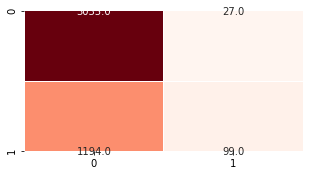

A acurácia foi de 71.96%.
Atributos mais relevantes para a decisão se o produto é interessante/não interessante
Atributo: ITEM_PRICE - Importância: 45.2453831882%
Atributo: TIPO_PRODUTO_PIPOQUEIRA - Importância: 16.4994445998%
Atributo: PESO - Importância: 8.6815446784%
Atributo: COR_VERMELHO - Importância: 8.3261470269%
Atributo: TEMPO_GARANTIA - Importância: 5.7023134529%
----------------------------------------------------------------------------------------------------
Modelo SVC
Matriz de Confusão:


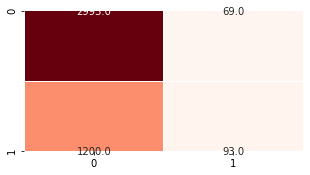

A acurácia foi de 70.86%.
Não implementado o classificador
----------------------------------------------------------------------------------------------------
Modelo Regressão Logística
Matriz de Confusão:


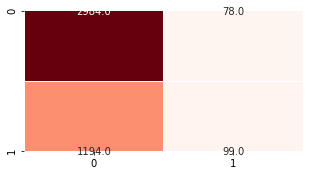

A acurácia foi de 70.79%.
Não implementado o classificador
----------------------------------------------------------------------------------------------------
Modelo Random Forest
Matriz de Confusão:


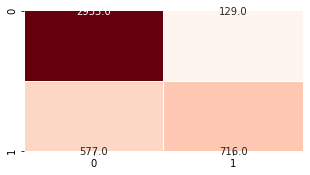

A acurácia foi de 83.79%.
Atributos mais relevantes para a decisão se o produto é interessante/não interessante
Atributo: ITEM_PRICE - Importância: 75.9793326503%
Atributo: ALTURA - Importância: 2.9330775989%
Atributo: PROFUNDIDADE - Importância: 2.9000871969%
Atributo: LARGURA - Importância: 2.7366370373%
Atributo: PESO - Importância: 1.8599608884%


In [11]:
panela.carregar_produto()
panela.classificar_literal_produto()
panela.aplicar_ml(escalar=True, sem_kfold=True)

Com KFold

----------------------------------------------------------------------------------------------------
Modelo Árvore de Decisão
Matriz de Confusão:


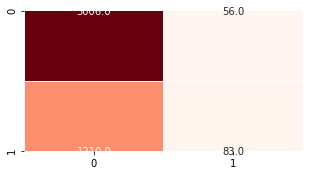

Acurácia média: 70.63%
Intervalo de acurácia: [69.71% ~ 71.55%]
Atributos mais relevantes para a decisão se o produto é interessante/não interessante - estimador 0
Atributo: ITEM_PRICE - Importância: 43.2680842680%
Atributo: TIPO_PRODUTO_PIPOQUEIRA - Importância: 15.8692587426%
Atributo: COR_COLORIDO - Importância: 6.7579990402%
Atributo: COR_VERMELHO - Importância: 5.8957588691%
Atributo: TEMPO_GARANTIA - Importância: 5.6088056789%
 
Atributos mais relevantes para a decisão se o produto é interessante/não interessante - estimador 1
Atributo: ITEM_PRICE - Importância: 47.7111001419%
Atributo: TIPO_PRODUTO_PIPOQUEIRA - Importância: 14.2134321274%
Atributo: COR_VERMELHO - Importância: 8.8286062014%
Atributo: FORMATO_INDEFINIDO - Importância: 5.8248124759%
Atributo: FORMATO_REDONDO - Importância: 5.1191900893%
 
Atributos mais relevantes para a decisão se o produto é interessante/não interessante - estimador 2
Atributo: ITEM_PRICE - Importância: 43.0773113998%
Atributo: ALTURA - Importânc

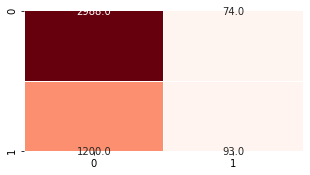

Acurácia média: 70.79%
Intervalo de acurácia: [69.35% ~ 72.23%]
Atributos mais relevantes para a decisão se o produto é interessante/não interessante - estimador 0
Não implementado o classificador
----------------------------------------------------------------------------------------------------
Modelo Regressão Logística
Matriz de Confusão:


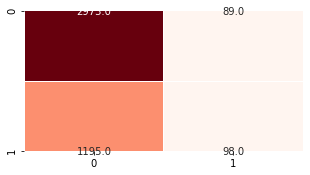

Acurácia média: 70.29%
Intervalo de acurácia: [69.17% ~ 71.41%]
Atributos mais relevantes para a decisão se o produto é interessante/não interessante - estimador 0
Não implementado o classificador
----------------------------------------------------------------------------------------------------
Modelo Random Forest
Matriz de Confusão:


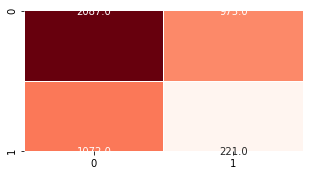

Acurácia média: 52.58%
Intervalo de acurácia: [49.62% ~ 55.55%]
Atributos mais relevantes para a decisão se o produto é interessante/não interessante - estimador 0
Atributo: ITEM_PRICE - Importância: 73.5489161595%
Atributo: PROFUNDIDADE - Importância: 3.1614131463%
Atributo: ALTURA - Importância: 3.1275765586%
Atributo: LARGURA - Importância: 2.8773303709%
Atributo: PESO - Importância: 2.0144658279%
 
Atributos mais relevantes para a decisão se o produto é interessante/não interessante - estimador 1
Atributo: ITEM_PRICE - Importância: 72.9460200896%
Atributo: ALTURA - Importância: 3.4496610108%
Atributo: PROFUNDIDADE - Importância: 3.1796330765%
Atributo: LARGURA - Importância: 2.9911943690%
Atributo: PESO - Importância: 2.0886483378%
 
Atributos mais relevantes para a decisão se o produto é interessante/não interessante - estimador 2
Atributo: ITEM_PRICE - Importância: 73.0465404015%
Atributo: ALTURA - Importância: 3.4054988281%
Atributo: PROFUNDIDADE - Importância: 3.2710735401%
Atr

In [12]:
panela.carregar_produto()
panela.calcular_dado_produto()
panela.classificar_literal_produto()
panela.aplicar_ml(escalar=True, excluir_linha_nulo=True, sem_kfold=False)

Para as categorias com valores nulos, analisei e apliquei os modelos de forma separada excluindo as respectivas colunas

- Categorias aonde as colunas LARGURA, ALTURA, PESO, PROFUNDIDADE são nulas <b>'CREMEIRA', 'COZI-PASTA'</b>

----------------------------------------------------------------------------------------------------
Modelo Árvore de Decisão
Matriz de Confusão:


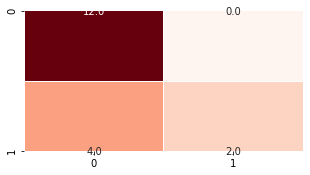

A acurácia foi de 77.78%.
Atributos mais relevantes para a decisão se o produto é interessante/não interessante
Atributo: ITEM_PRICE - Importância: 95.8333333333%
Atributo: COR_INOX - Importância: 4.1666666667%
Atributo: CAPACIDADE - Importância: 0.0000000000%
Atributo: PARA_LAVA_LOUCAS - Importância: 0.0000000000%
Atributo: PARA_MICRO_ONDAS - Importância: 0.0000000000%
----------------------------------------------------------------------------------------------------
Modelo SVC
Matriz de Confusão:


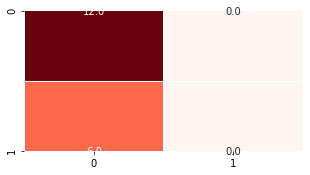

A acurácia foi de 66.67%.
Não implementado o classificador
----------------------------------------------------------------------------------------------------
Modelo Regressão Logística
Matriz de Confusão:


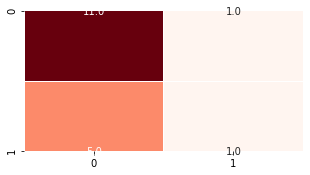

A acurácia foi de 66.67%.
Não implementado o classificador
----------------------------------------------------------------------------------------------------
Modelo Random Forest
Matriz de Confusão:


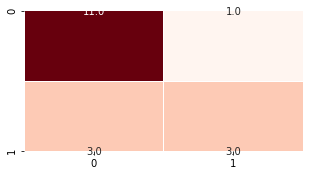

A acurácia foi de 77.78%.
Atributos mais relevantes para a decisão se o produto é interessante/não interessante
Atributo: ITEM_PRICE - Importância: 81.9533276329%
Atributo: CAPACIDADE - Importância: 3.8685869951%
Atributo: TIPO_PRODUTO_CREMEIRA - Importância: 3.5693280643%
Atributo: TIPO_PRODUTO_COZI-PASTA - Importância: 3.1578973810%
Atributo: TEMPO_GARANTIA - Importância: 2.8522032306%


In [13]:
panela.carregar_produto()
panela.df_produto = panela.df_produto[panela.df_produto.ALTURA.isnull()].copy()
panela.calcular_dado_produto()
panela.classificar_literal_produto()
panela.df_produto_ml.drop(columns=['LARGURA','ALTURA','PESO','PROFUNDIDADE'], inplace=True)
panela.aplicar_ml(excluir_linha_nulo=False, escalar=True, sem_kfold=True)

* Categoria aonde a coluna PESO é nula e a CAPACIDADE não é nula: <b>OMELETEIRA</b>

----------------------------------------------------------------------------------------------------
Modelo Árvore de Decisão
Matriz de Confusão:


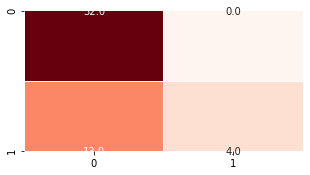

A acurácia foi de 73.47%.
Atributos mais relevantes para a decisão se o produto é interessante/não interessante
Atributo: ITEM_PRICE - Importância: 70.2901226969%
Atributo: COR_VERMELHO - Importância: 15.1750174402%
Atributo: LARGURA - Importância: 12.3230333621%
Atributo: COR_TURQUESA - Importância: 2.2118265009%
Atributo: ALTURA - Importância: 0.0000000000%
----------------------------------------------------------------------------------------------------
Modelo SVC
Matriz de Confusão:


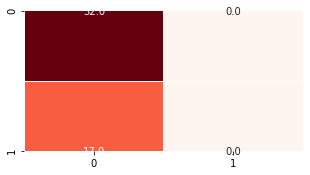

A acurácia foi de 65.31%.
Não implementado o classificador
----------------------------------------------------------------------------------------------------
Modelo Regressão Logística
Matriz de Confusão:


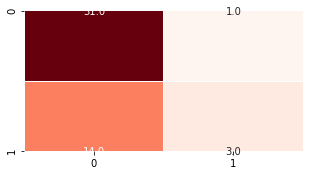

A acurácia foi de 69.39%.
Não implementado o classificador
----------------------------------------------------------------------------------------------------
Modelo Random Forest
Matriz de Confusão:


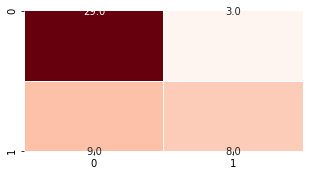

A acurácia foi de 75.51%.
Atributos mais relevantes para a decisão se o produto é interessante/não interessante
Atributo: ITEM_PRICE - Importância: 70.7903968509%
Atributo: COR_PRATA - Importância: 4.3243236918%
Atributo: LARGURA - Importância: 3.8536813677%
Atributo: COR_VERMELHO - Importância: 3.6394006489%
Atributo: FORMATO_REDONDO - Importância: 3.3193109974%


In [14]:
panela.carregar_produto()
panela.df_produto.drop(panela.df_produto[panela.df_produto.ALTURA.isnull()].index, inplace=True)
panela.df_produto = panela.df_produto[(panela.df_produto.PESO.isnull()) &  (~panela.df_produto.CAPACIDADE.isnull())].copy()
panela.calcular_dado_produto()
panela.classificar_literal_produto()
panela.df_produto_ml.drop(columns=['PESO'], inplace=True)
panela.aplicar_ml(excluir_linha_nulo=False, escalar=True, sem_kfold=True)

* Categoria aonde as colunas PESO e CAPACIDADE são nulas: <b>'CHAPA', 'FONDUE', 'MINI-CACAROLA', 'BIFETEIRA', 'CUMBUCA','FRITADEIRA', 'SANDUICHEIRA', 'FORMA', 'ASSADEIRA', 'TAMPA','FOGAREIRO', 'PRENSADOR', 'FORNO', 'CANECA/FERVEDOR'</b>

----------------------------------------------------------------------------------------------------
Modelo Árvore de Decisão
Matriz de Confusão:


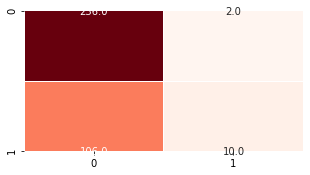

A acurácia foi de 69.49%.
Atributos mais relevantes para a decisão se o produto é interessante/não interessante
Atributo: ITEM_PRICE - Importância: 62.7260420969%
Atributo: ALTURA - Importância: 9.3855128392%
Atributo: TIPO_PRODUTO_CUMBUCA - Importância: 6.1353028904%
Atributo: TIPO_PRODUTO_FONDUE - Importância: 5.8460883616%
Atributo: FORMATO_REDONDO - Importância: 5.6192010729%
----------------------------------------------------------------------------------------------------
Modelo SVC
Matriz de Confusão:


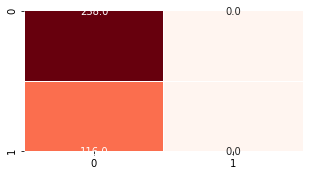

A acurácia foi de 67.23%.
Não implementado o classificador
----------------------------------------------------------------------------------------------------
Modelo Regressão Logística
Matriz de Confusão:


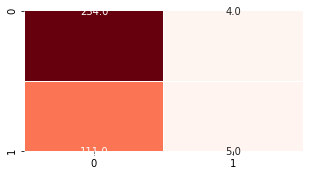

A acurácia foi de 67.51%.
Não implementado o classificador
----------------------------------------------------------------------------------------------------
Modelo Random Forest
Matriz de Confusão:


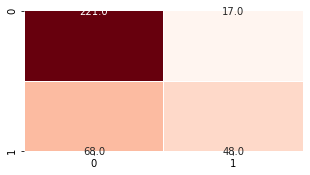

A acurácia foi de 75.99%.
Atributos mais relevantes para a decisão se o produto é interessante/não interessante
Atributo: ITEM_PRICE - Importância: 63.5991561592%
Atributo: PROFUNDIDADE - Importância: 4.7141217666%
Atributo: LARGURA - Importância: 4.4923892378%
Atributo: ALTURA - Importância: 4.3054065737%
Atributo: FORMATO_REDONDO - Importância: 1.9155725922%


In [15]:
panela.carregar_produto()
panela.df_produto.drop(panela.df_produto[panela.df_produto.ALTURA.isnull()].index, inplace=True)
panela.df_produto.drop(panela.df_produto[(panela.df_produto.PESO.isnull()) &  (~panela.df_produto.CAPACIDADE.isnull())].index, inplace=True)
panela.df_produto = panela.df_produto[(panela.df_produto.PESO.isnull()) &  (panela.df_produto.CAPACIDADE.isnull())].copy()
panela.calcular_dado_produto()
panela.classificar_literal_produto()
panela.df_produto_ml.drop(columns=['PESO','CAPACIDADE'], inplace=True)
panela.aplicar_ml(excluir_linha_nulo=False, escalar=True, sem_kfold=True)

* Categoria aonde apenas a coluna CAPACIDADE é nula: <b>'CUSCUZEIRA', 'PANQUEQUEIRA', 'CUSCUZEIRO', 'BISTEQUEIRA','VAPORELLA'</b>

----------------------------------------------------------------------------------------------------
Modelo Árvore de Decisão
Matriz de Confusão:


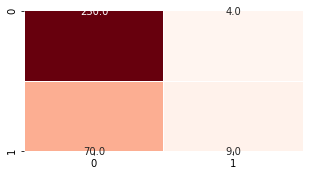

A acurácia foi de 76.36%.
Atributos mais relevantes para a decisão se o produto é interessante/não interessante
Atributo: ITEM_PRICE - Importância: 68.3026236503%
Atributo: ALTURA - Importância: 10.0619773085%
Atributo: PESO - Importância: 7.0601011978%
Atributo: COMPOSICAO_INOX - Importância: 5.9738522110%
Atributo: COR_CEREJA - Importância: 3.5360139228%
----------------------------------------------------------------------------------------------------
Modelo SVC
Matriz de Confusão:


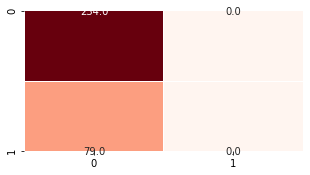

A acurácia foi de 74.76%.
Não implementado o classificador
----------------------------------------------------------------------------------------------------
Modelo Regressão Logística
Matriz de Confusão:


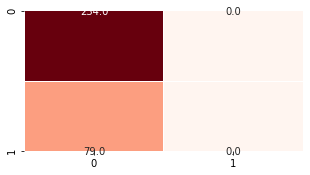

A acurácia foi de 74.76%.
Não implementado o classificador
----------------------------------------------------------------------------------------------------
Modelo Random Forest
Matriz de Confusão:


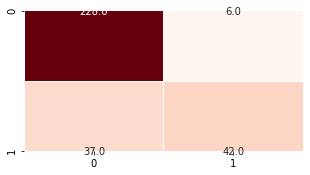

A acurácia foi de 86.26%.
Atributos mais relevantes para a decisão se o produto é interessante/não interessante
Atributo: ITEM_PRICE - Importância: 91.4607557011%
Atributo: PROFUNDIDADE - Importância: 1.1379614228%
Atributo: ALTURA - Importância: 0.9243336289%
Atributo: PESO - Importância: 0.7729996695%
Atributo: LARGURA - Importância: 0.7383372488%


In [16]:
panela.carregar_produto()
panela.df_produto.drop(panela.df_produto[panela.df_produto.ALTURA.isnull()].index, inplace=True)
panela.df_produto.drop(panela.df_produto[(panela.df_produto.PESO.isnull()) &  (~panela.df_produto.CAPACIDADE.isnull())].index, inplace=True)
panela.df_produto.drop(panela.df_produto[(panela.df_produto.PESO.isnull()) &  (panela.df_produto.CAPACIDADE.isnull())].index, inplace=True)
panela.df_produto = panela.df_produto[panela.df_produto.CAPACIDADE.isnull()].copy()
panela.calcular_dado_produto()
panela.classificar_literal_produto()
panela.df_produto_ml.drop(columns=['CAPACIDADE'], inplace=True)
panela.aplicar_ml(excluir_linha_nulo=False, escalar=True, sem_kfold=True)

<h4>CONCLUSÃO</h4>


O seu objetivo principal é desenvolver um modelo que consiga classificar o produto entre "interessante" e "não interessante" dados os atributos do mesmo. Além disso, é desejável que você também consiga indicar quais são os atributos e respectivos valores que mais impulsionam o interesse do cliente.<br>

Na análise o modelo Floresta aleatório a princípio é o modelo que melhor desempenha nesse caso.<br>
É possível perceber que em todos os casos, os 5 primeiros atributos que mais definem se um produto é <i>interessante/não interessante</i> para o cliente, são:<br>